# plot_ripple_trace

plot ripple example for figure 1

In [1]:
import pickle
import numpy as np
# plotting
from matplotlib import pyplot as plt
# import dabest
import pandas as pd
from scipy import stats
import h5py
import sys,os
import glob
from ripple_detection import filter_ripple_band
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Continuous Wavelet Transform
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

import sys
sys.path.append("/Users/ryanharvey/github/tg_ripples/tg_ripples")
from functions import *

from neurodsp.filt import filter_signal


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

## helper functions

In [3]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch


def get_lfp(df,i):
    data_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/ProcessedData/'

    # get data session path from mat file
    path = get_session_path(data_path+df.session[i])
    file_sep = os.path.sep

    path = glob.glob((data_path.split('ClarkP30_Recordings')[0]+
              path.split('\\')[-4]+
              file_sep+
              '**'+
              file_sep+path.split('\\')[-1]+file_sep),
              recursive=True)
    path=path[0]
    
    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path + file_sep + '*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def normalize(list, range):
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]
    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def get_scalogram(sig,fs=1250,padding=100,f_min=150,f_max=250,fig=1,ax=0):
    
    # sample difference
    dt = 1/fs
    # pad signal
    sig_padded = np.pad(sig, (padding, padding), 'linear_ramp')
    # get time stamps
    t = np.linspace(0, dt * len(sig), len(sig))
    # get scalogram
    scalogram = cwt(sig_padded, dt, 8, f_min, f_max)
    # delete padding
    scalogram = np.delete(scalogram, np.s_[1:padding+1], axis=1) 
    scalogram = np.delete(scalogram, np.s_[-(padding+1):-1], axis=1) 
    
    # plot figure
    if fig==1:
        cmap = plt.get_cmap('magma')
        if ax == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        x, y = np.meshgrid(
            t,
            np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        im = ax.pcolormesh(x, y, np.abs(scalogram), cmap=cmap,shading='auto')
        ax.set_rasterized(True)
        ax.plot(t,normalize(sig,[f_min,f_max]),color='w',linewidth=1)
        ax.set_ylabel("Frequency [Hz]")
        ax.set_ylim(f_min, f_max)
        # ax.set_yscale('log')
        if ax == 0:
            plt.show()
    
    return np.abs(scalogram),im

## Load data

In [4]:
csv_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/swr_data/post_processed/swr_df.csv'

df = pd.read_csv(csv_path)
df

,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,ep_type,group,rat
0,0,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054,ep_1,tg,ATN07
1,1,37,1249.616538,1249.689538,0.073000,1249.655538,4,4.094174,162.455893,0.000000,ATN07_S20180918160054,ep_3,tg,ATN07
2,2,57,1528.019700,1528.132700,0.113000,1528.053700,5,3.569597,131.126268,0.000000,ATN07_S20180918160054,ep_3,tg,ATN07
3,3,58,1581.596539,1581.788538,0.191999,1581.741538,4,9.663464,142.733218,0.006667,ATN07_S20180918160054,ep_3,tg,ATN07
4,4,82,2764.205267,2764.258267,0.053000,2764.234267,3,10.114827,119.693525,0.006667,ATN07_S20180918160054,1,tg,ATN07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,5790,12,1275.821997,1275.857996,0.036000,1275.841996,2,6.866176,132.811124,0.006667,ATN15_S20190425170132,ep_3,tg,ATN15
5522,5791,15,1372.227543,1372.310542,0.083000,1372.287543,3,8.187005,108.978288,0.013333,ATN15_S20190425170132,ep_3,tg,ATN15
5523,5792,17,2159.908836,2160.734833,0.825996,2160.520834,7,13.361331,113.397813,0.020000,ATN15_S20190425170132,1,tg,ATN15
5524,5793,18,2178.055751,2178.344750,0.288999,2178.217750,3,82.747517,103.436299,0.000000,ATN15_S20190425170132,1,tg,ATN15


# function to plot ripple examples

In [5]:
def plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs,ts,save_path):
    # set up figure
    fig = plt.figure(figsize=set_size('thesis',fraction=.5,subplots=(1,1)),constrained_layout=False)
    fig.subplots_adjust(hspace = 0, wspace=0.5)
    gs = fig.add_gridspec(3, 1)
    f_ax1 = fig.add_subplot(gs[0:2, :])
    f_ax2 = fig.add_subplot(gs[2, :])

    # plot scalogram
    _,im = get_scalogram(LFPs[idx,df.peak_channel[rip_n]],1250,f_min=80,f_max=350,ax=f_ax1)
    f_ax1.set_xlabel('time (sec)')
    f_ax1.get_xaxis().set_visible(False)

    # set up parameters for colorbar
    axins = inset_axes(f_ax1,
                       width="2%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=f_ax1.transAxes,
                       borderpad=0,
                       )
    # plot colorbar
    cbar = fig.colorbar(im,ax=f_ax1,cax=axins)
    cbar.set_label('Magnitude', rotation=270, labelpad=20)
    cbar.outline.set_visible(False)

    # plot filtered trace
    f_ax2.plot(ts[idx],filtered_lfps[idx,df.peak_channel[rip_n]],color='k',linewidth=0.8)
    for ripple in temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)].itertuples():
        f_ax2.axvspan(ripple.start_time, ripple.end_time, alpha=0.2, color='red', zorder=-1000) # #fec287

    f_ax2.autoscale(enable=True, axis='x', tight=True)

    # align x axis
    locs = f_ax2.get_xticks()
    labels = f_ax2.get_xticklabels()
    f_ax2.set_xticks(np.linspace(min(ts[idx]), max(ts[idx]), 5))
    f_ax2.set_xticklabels(np.linspace(-x_range/2,x_range/2,5))

    # name x axis
    f_ax2.set_xlabel('time (sec)')

    # clean up y axis and box
    f_ax2.get_yaxis().set_visible(False)
    right_side = f_ax2.spines["right"]
    right_side.set_visible(False)
    left_side = f_ax2.spines["left"]
    left_side.set_visible(False)
    top_side = f_ax2.spines["top"]
    top_side.set_visible(False)

    # save plot
    # plt.savefig('ripple_trace_spectro.svg',dpi=900,bbox_inches='tight')
    if not os.path.exists(save_path+df.group[rip_n]+'_ripple_examples'):
        os.mkdir(save_path+df.group[rip_n]+'_ripple_examples')
        
    plt.savefig(save_path+df.group[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.png',dpi=300,bbox_inches='tight')
    plt.savefig(save_path+df.group[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.svg',dpi=300,bbox_inches='tight')

## Chose ripple number, load data, and plot example ripple

In [6]:
# rip_n = 21568
# rip_n = 21682
rip_n = 100
lfp,ts = get_lfp(df,rip_n)

filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
filtered_lfps = filtered_lfps.T

# LFPs = lfp
# filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
# filtered_lfps = filtered_lfps.T

x_range = .200
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

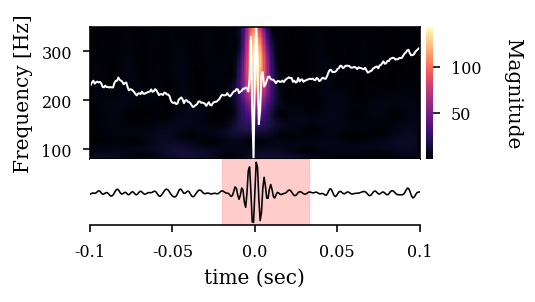

In [23]:
save_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/figures/ripple_examples/'

plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)

# run through each ripple with the below parameters

In [ ]:
def get_example_idx(df,group,frac_std=1):
    idx = (df.group == group)
    # get median values
    ripple_duration = np.median(df.ripple_duration[idx])
    ripple_duration_std = np.std(df.ripple_duration[idx]) * frac_std

    peak_freq = np.median(df.peak_freq[idx])
    peak_freq_std = np.std(df.peak_freq[idx]) * frac_std

    peak_amplitude = np.median(df.peak_amplitude[idx])
    peak_amplitude_std = np.std(df.peak_amplitude[idx]) * frac_std

    idx = ((df.group == group)
        & (df.ripple_duration > ripple_duration-ripple_duration_std)
        & (df.ripple_duration < ripple_duration+ripple_duration_std)
        & (df.peak_freq > peak_freq-peak_freq_std)
        & (df.peak_freq < peak_freq+peak_freq_std)
        & (df.peak_amplitude > peak_amplitude-peak_amplitude_std)
        & (df.peak_amplitude < peak_amplitude+peak_amplitude_std))

    return idx

def run_though_idx(df,idx):
    save_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/figures/ripple_examples/'

    for rip_n in df[idx].index:
        lfp,ts = get_lfp(df,rip_n)

        filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
        filtered_lfps = filtered_lfps.T

        x_range = .200
        idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
        temp_df = df[df.session == df.session[rip_n]]

        plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)
    
idx = get_example_idx(df,'wt',frac_std=.25)
run_though_idx(df,idx)

idx = get_example_idx(df,'tg',frac_std=.5)
run_though_idx(df,idx)


In [ ]:
idx = get_example_idx(df,'tg',frac_std=.5)
run_though_idx(df,idx)

In [10]:
def plot_this_ripple(df,rip_n,save_path):
    
    lfp,ts = get_lfp(df,rip_n)

    filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
    filtered_lfps = filtered_lfps.T

    x_range = .300
    idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
    temp_df = df[df.session == df.session[rip_n]]

    plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)

Unnamed: 0                          1127
ripple_number                        348
start_time                     2879.2376
end_time                       2879.3432
ripple_duration                   0.1056
peak_time                      2879.2944
peak_channel                           3
peak_amplitude                  6.194075
peak_freq                     128.229707
clipped                         0.013333
session            ATN17_S20190718131202
ep_type                                1
group                                 wt
rat                                ATN17
Name: 1091, dtype: object

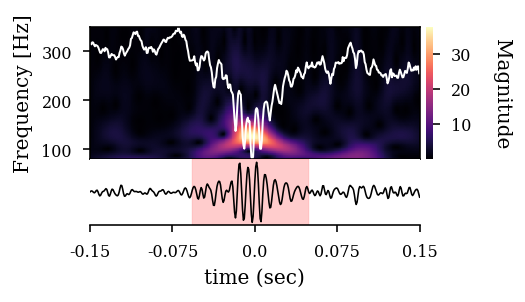

In [11]:
save_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/figures/ripple_examples/'

rip_n = 1091
display(df.loc[rip_n])
plot_this_ripple(df,rip_n,save_path)

Unnamed: 0                          3742
ripple_number                        199
start_time                   3623.872735
end_time                     3623.936735
ripple_duration                    0.064
peak_time                    3623.900735
peak_channel                           0
peak_amplitude                  4.425532
peak_freq                     135.655348
clipped                         0.006667
session            ATN07_S20180723173344
ep_type                             ep_5
group                                 tg
rat                                ATN07
Name: 3565, dtype: object

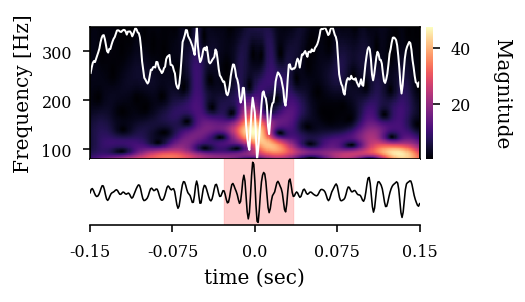

In [12]:
rip_n = 3565
display(df.loc[rip_n])
plot_this_ripple(df,rip_n,save_path)

In [37]:
df[df.group == 'tg']

,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,ep_type,group,rat
0,0,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054,ep_1,tg,ATN07
1,1,37,1249.616538,1249.689538,0.073000,1249.655538,4,4.094174,162.455893,0.000000,ATN07_S20180918160054,ep_3,tg,ATN07
2,2,57,1528.019700,1528.132700,0.113000,1528.053700,5,3.569597,131.126268,0.000000,ATN07_S20180918160054,ep_3,tg,ATN07
3,3,58,1581.596539,1581.788538,0.191999,1581.741538,4,9.663464,142.733218,0.006667,ATN07_S20180918160054,ep_3,tg,ATN07
4,4,82,2764.205267,2764.258267,0.053000,2764.234267,3,10.114827,119.693525,0.006667,ATN07_S20180918160054,1,tg,ATN07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,5790,12,1275.821997,1275.857996,0.036000,1275.841996,2,6.866176,132.811124,0.006667,ATN15_S20190425170132,ep_3,tg,ATN15
5522,5791,15,1372.227543,1372.310542,0.083000,1372.287543,3,8.187005,108.978288,0.013333,ATN15_S20190425170132,ep_3,tg,ATN15
5523,5792,17,2159.908836,2160.734833,0.825996,2160.520834,7,13.361331,113.397813,0.020000,ATN15_S20190425170132,1,tg,ATN15
5524,5793,18,2178.055751,2178.344750,0.288999,2178.217750,3,82.747517,103.436299,0.000000,ATN15_S20190425170132,1,tg,ATN15


In [39]:
idx = (df.ripple_duration > .08) & (df.ripple_duration < .150) & (df.group == 'tg') & (df.peak_amplitude > 5) & (df.peak_amplitude < 15) & (df.peak_freq > 105) & (df.peak_freq < 200)
df[idx]

,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,ep_type,group,rat
6,6,92,2804.771145,2804.900144,0.1290,2804.843145,3,6.693300,143.836575,0.006667,ATN07_S20180918160054,1,tg,ATN07
90,94,22,1428.652800,1428.792000,0.1392,1428.713600,6,10.236051,117.688090,0.000000,ATN15_S20190430154146,ep_2,tg,ATN15
93,97,25,1433.512000,1433.604800,0.0928,1433.532800,6,10.091925,130.243668,0.000000,ATN15_S20190430154146,ep_2,tg,ATN15
99,103,49,1670.569600,1670.667200,0.0976,1670.630400,2,13.565184,177.958806,0.000000,ATN15_S20190430154146,ep_2,tg,ATN15
101,105,65,2832.424800,2832.525600,0.1008,2832.440800,7,9.021536,153.376354,0.000000,ATN15_S20190430154146,1,tg,ATN15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477,5743,54,1539.044807,1539.155806,0.1110,1539.074807,2,6.643980,191.741619,0.000000,ATN15_S20190404173628,ep_3,tg,ATN15
5478,5744,62,2517.458870,2517.566869,0.1080,2517.544869,2,8.516010,147.784413,0.000000,ATN15_S20190404173628,1,tg,ATN15
5480,5746,82,2729.157018,2729.269018,0.1120,2729.228018,7,8.278221,194.576210,0.000000,ATN15_S20190404173628,1,tg,ATN15
5502,5768,142,3398.836323,3398.953323,0.1170,3398.914323,3,9.645383,184.387329,0.000000,ATN15_S20190404173628,1,tg,ATN15


In [ ]:
from IPython.display import display, clear_output

# idx = (df.ripple_duration > .05) & (df.ripple_duration < .07) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_freq > 200) & (df.peak_freq < 230)
idx = (df.ripple_duration > .1) & (df.ripple_duration < .200) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_amplitude < 15) & (df.peak_freq > 105) & (df.peak_freq < 115)

for rip_n in df[idx].index:
    lfp,ts = get_lfp(df,rip_n)

    filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
    filtered_lfps = filtered_lfps.T
    
    x_range = .200
    idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
    temp_df = df[df.session == df.session[rip_n]]
    
    plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,save_path)
    clear_output()

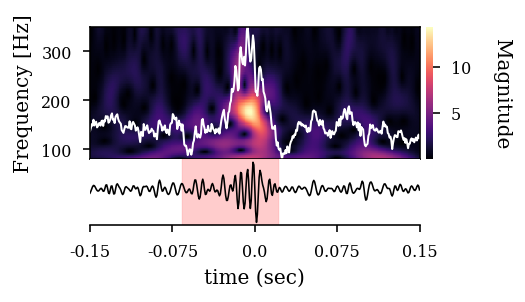

In [58]:
rip_n = 17058
rip_n = 5707
rip_n = 12339
rip_n = 3034

lfp,ts = get_lfp(df,rip_n)

filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
filtered_lfps = filtered_lfps.T

x_range = .300
idx = (ts >= df.peak_time.iloc[rip_n] - x_range/2) & (ts <= df.peak_time.iloc[rip_n] + x_range/2)
temp_df = df[df.session == df.session.iloc[rip_n]]

save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_section/'

plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)
